In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])
dataset = torchvision.datasets.MNIST('../../data/mnist', train=True, transform=transform, download=False)

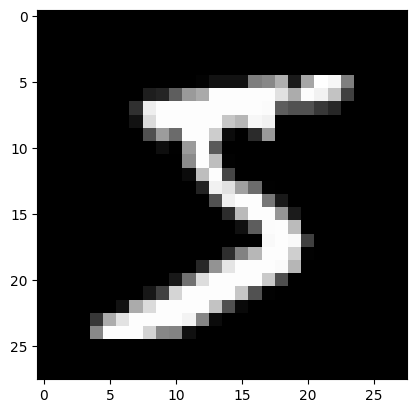

In [3]:
plt.imshow(dataset[0][0].permute(1, 2, 0), cmap='gray');

In [4]:
def show_images(images, title=None):
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid((images + 1) / 2).permute(1, 2, 0))
    if title is not None:
        plt.title(title)
    plt.show()

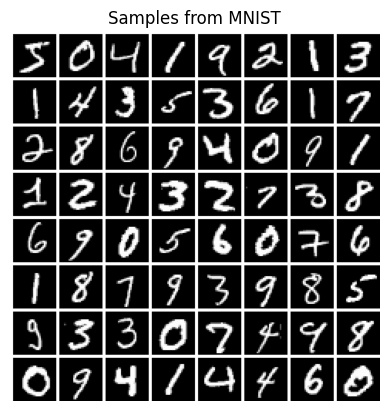

In [5]:
show_images(torch.stack([dataset[i][0] for i in range(64)]), title='Samples from MNIST');

In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim, hidden_dim, img_channels):
        super().__init__()

        self.net = nn.Sequential(
            self.__basic_block(in_channels=z_dim, out_channels=hidden_dim*4, kernel_size=3, stride=1),
            self.__basic_block(in_channels=hidden_dim*4, out_channels=hidden_dim*2, kernel_size=4, stride=1),
            self.__basic_block(in_channels=hidden_dim*2, out_channels=hidden_dim, kernel_size=3, stride=2),
            nn.ConvTranspose2d(hidden_dim, img_channels, kernel_size=4, stride=2),
            nn.Tanh(),
        )
    
    def __basic_block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.net(x)

In [7]:
noise = torch.randn(1, 100, 1, 1)
Generator(100, 64, 1)(noise).shape

torch.Size([1, 1, 28, 28])

In [8]:
class Discriminative(nn.Module):
    def __init__(self, img_channels, hidden_dim):
        super().__init__()
        
        self.net = nn.Sequential(
            self.__basic_block(img_channels, hidden_dim, kernel_size=4, stride=2),
            self.__basic_block(hidden_dim, hidden_dim*2, kernel_size=4, stride=2),
            nn.Conv2d(hidden_dim*2, 1, kernel_size=4, stride=2),
        )

    def __basic_block(self, in_channels, out_channels, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.2)
        )

    def forward(self, x):
        return self.net(x).view(x.size(0), 1)

In [9]:
x = torch.randn(32, 1, 28, 28)
Discriminative(1, 1)(x).shape

torch.Size([32, 1])

In [10]:
FLATTENED_IMAGE_SIZE = dataset[0][0].numel()
NOISE_DIM = 64
BATCH_SIZE = 128
NUM_EPOCHS = 30
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [11]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [12]:
gen = Generator(z_dim=NOISE_DIM, hidden_dim=64, img_channels=1).to(device).apply(init_weights)
disc = Discriminative(img_channels=1, hidden_dim=16).to(device).apply(init_weights)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
criterion = nn.BCEWithLogitsLoss()

opt_gen = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

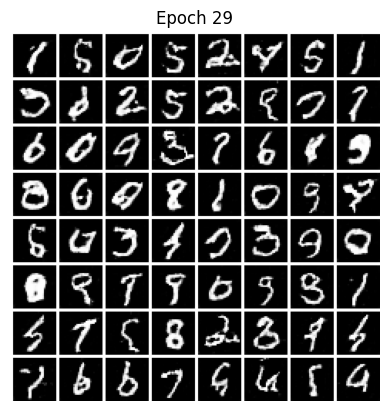

In [13]:
fixed_noise = torch.randn(64, NOISE_DIM, 1, 1).to(device)
images = []
transf = transforms.Compose([transforms.ToPILImage(), transforms.Lambda(lambda x: np.array(x)[:, :, 0])])

for epoch in range(NUM_EPOCHS):
    for real_images, _ in dataloader:
        real_images = real_images.to(device)

        #----- Updating the Discriminator -----#
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake_images = gen(noise).detach()
        fake_loss = criterion(disc(fake_images), torch.zeros(fake_images.size(0), 1).to(device))
        real_loss = criterion(disc(real_images), torch.ones(real_images.size(0), 1).to(device))
        loss = (fake_loss + real_loss) / 2
        disc.zero_grad()
        loss.backward()
        opt_disc.step()

        #----- Updating the Generator -----#
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        loss = criterion(disc(gen(noise)), torch.ones(BATCH_SIZE, 1).to(device))
        gen.zero_grad()
        loss.backward()
        opt_gen.step()

    clear_output()
    show_images(gen(fixed_noise).detach().cpu(), title=f"Epoch {epoch}")
    images.append(transf(torchvision.utils.make_grid((gen(fixed_noise) + 1) / 2).detach().cpu()))


In [14]:
import cv2

video = cv2.VideoWriter("output.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 5, (240, 240), False)
for image in images:
    video.write(image)
video.release()
cv2.destroyAllWindows()

In [15]:
import imageio

imageio.mimsave('output.gif', images, fps=5)

![](output.gif)

## Exploring the Learned Representation (Z) 

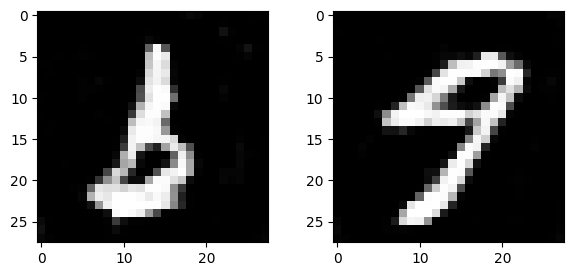

In [65]:
noise = torch.randn(2, NOISE_DIM, 1, 1).to(device)
images = gen(noise).detach().cpu().permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
axs[0].imshow(images[0], cmap="gray")
axs[1].imshow(images[1], cmap="gray");

In [74]:
cnt = 15
step = (noise[1] - noise[0]) / cnt
interpolated_noises = []
for i in range(cnt+1):
    interpolated_noises.append(noise[0] + step * i)

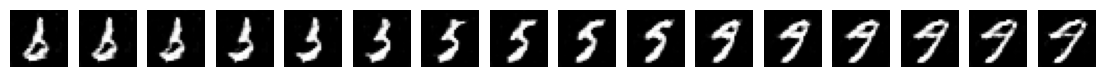

In [75]:
interpolated_images = gen(torch.stack(interpolated_noises)).detach().cpu().permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, cnt+1, figsize=(14, 2))
for i in range(cnt+1):
    axs[i].axis("off")
    axs[i].imshow(interpolated_images[i], cmap="gray")

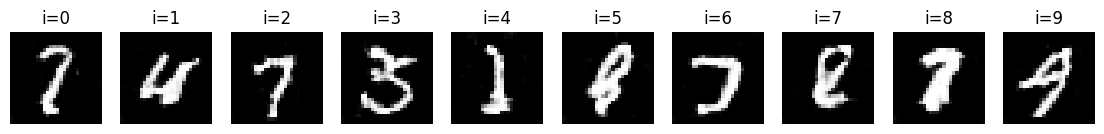

In [107]:
noise = torch.randn(10, NOISE_DIM, 1, 1).to(device)
images = gen(noise).detach().cpu().permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, 10, figsize=(14, 3))
for i in range(10):
    axs[i].axis("off")
    axs[i].imshow(images[i], cmap="gray")
    axs[i].set_title(f"i={i}")

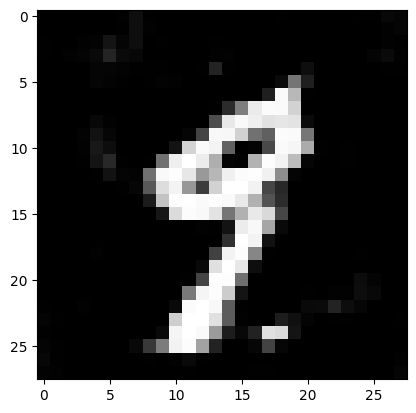

In [109]:
new_noise = noise[2] - noise[8] + noise[9]
plt.imshow(gen(new_noise.unsqueeze(0)).squeeze(0).detach().cpu().permute(1, 2, 0), cmap="gray");